In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import sklearn
import seaborn as sns
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import linear_model

In [53]:
url = 'Non_Eruption_Analysis.csv'
non_erupting = pd.read_csv(url)
non_erupting = non_erupting.drop('Unnamed: 0', axis=1)
non_erupting.replace('Na',np.nan, inplace=True)
non_erupting['Eruption'] = 0
non_erupting.head()
#non_erupting.keys()


,Track No.,fi_length_avg,length_slp,fi_area_avg,area_slp,fi_chiral_avg,chiral_slp,fi_tilt_avg,tilt_slp,Eruption
0,64,1.910054e+10,-20851.523458,4899.559437,-0.017645,0.400000,-0.259382,46.965340,-3.110127,0
1,78,9.040830e+09,19070.132868,1100.649604,0.001371,-0.333333,-0.836622,-33.939233,0.316939,0
2,98,6.642232e+09,5826.291102,1461.183990,-0.000051,0.285714,0.864459,2.343557,-1.330016,0
3,106,1.047587e+10,19895.431452,1288.497093,0.003803,0.222222,0.832329,-21.837421,0.671030,0
4,135,4.836125e+09,-14971.593714,353.247685,-0.001294,-0.200000,2.301987,-37.236174,0.481864,0


In [54]:
url = 'Eruption_Analysis.csv'

erupting = pd.read_csv(url)
erupting = erupting.drop('Unnamed: 0', axis=1)
erupting.replace('Na',np.nan, inplace=True)
erupting = erupting.astype(float)
erupting['Eruption'] = 1
erupting = erupting.dropna()
erupting.head()

,Track No.,fi_length_avg,length_slp,fi_area_avg,area_slp,fi_chiral_avg,chiral_slp,fi_tilt_avg,tilt_slp,Eruption
1,21,4.843297e+09,14271.123747,476.062630,-0.002162,0.000000,0.000000,-55.760900,-6.176173,1
3,93,1.140865e+10,5635.917614,4542.134217,-0.004866,0.000000,4.706329,-9.283704,-4.488977,1
4,94,2.242780e+10,-26760.784806,5584.925487,-0.007008,-0.142857,-3.257830,33.833814,-0.721631,1
5,140,1.219793e+10,100417.840826,3487.984499,0.029020,0.250000,0.242555,17.280300,4.510884,1
6,175,1.381954e+10,12941.709122,5210.939558,0.007604,0.400000,-1.354914,-22.194140,-0.169296,1


# Running various K-S tests to see which parameters may be good to test

In [5]:
#KS test for filament length
erupt_len = erupting['fi_length_avg'].tolist()
nerupt_len = non_erupting['fi_length_avg'].tolist()
stats.ks_2samp(erupt_len, nerupt_len)

(0.10255562899317039, 0.67609716385090435)

In [6]:
#KS test for change in length (slope)
erupt_slen = erupting['length_slp'].dropna().tolist()
nerupt_slen = non_erupting['length_slp'].dropna().tolist()
stats.ks_2samp(erupt_slen, nerupt_slen)

(0.22758316809870016, 0.011957756784611816)

In [7]:
erupt_area = erupting['fi_area_avg'].tolist()
nerupt_area = non_erupting['fi_area_avg'].tolist()
stats.ks_2samp(erupt_area, nerupt_area)

(0.10343688037012566, 0.66566065133367547)

In [8]:
#KS test for change in area (slope)
erupt_sarea = erupting['area_slp'].dropna().astype(float).tolist()
nerupt_sarea = non_erupting['area_slp'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_sarea, nerupt_sarea)

(0.25501211720643313, 0.0032316014476262644)

In [9]:
erupt_chiral = erupting['fi_chiral_avg'].tolist()
nerupt_chiral = non_erupting['fi_chiral_avg'].tolist()
stats.ks_2samp(erupt_chiral, nerupt_chiral)

(0.13395020929720203, 0.33780937778231418)

In [10]:
erupt_schiral = erupting['chiral_slp'].dropna().astype(float).tolist()
nerupt_schiral = non_erupting['chiral_slp'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_schiral, nerupt_schiral)

(0.13350958360872439, 0.34170772106786046)

In [11]:
erupt_tilt = erupting['fi_tilt_avg'].tolist()
nerupt_tilt = non_erupting['fi_tilt_avg'].tolist()
stats.ks_2samp(erupt_tilt, nerupt_tilt)

(0.16732760519938311, 0.12560920279014981)

In [12]:
erupt_stilt = erupting['tilt_slp'].dropna().astype(float).tolist()
nerupt_stilt = non_erupting['tilt_slp'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_stilt, nerupt_stilt)

(0.20962767129323645, 0.025980204834566659)

# Preparing for random forest classifier by putting erupting/nonerupting data together

In [13]:
##Now lets see if we can predict whether a filament will erupt or not. 
erupting = erupting.astype(float)
all_eruptions=erupting.append(non_erupting,ignore_index = True)   #adding everything together
all_eruptions = all_eruptions.dropna() #for now, dropping everything with NaN
all_eruptions.head()

,Track No.,fi_length_avg,length_slp,fi_area_avg,area_slp,fi_chiral_avg,chiral_slp,fi_tilt_avg,tilt_slp,Eruption
0,21,4.843297e+09,14271.123747,476.062630,-0.002162,0.000000,0.000000,-55.760900,-6.176173,1
1,93,1.140865e+10,5635.917614,4542.134217,-0.004866,0.000000,4.706329,-9.283704,-4.488977,1
2,94,2.242780e+10,-26760.784806,5584.925487,-0.007008,-0.142857,-3.257830,33.833814,-0.721631,1
3,140,1.219793e+10,100417.840826,3487.984499,0.029020,0.250000,0.242555,17.280300,4.510884,1
4,175,1.381954e+10,12941.709122,5210.939558,0.007604,0.400000,-1.354914,-22.194140,-0.169296,1


In [14]:
#Pull out the feature we want to predict (1 for eruption, 0 for no eruption)
Y = np.array(all_eruptions['Eruption'])  #getting the eruption status (variable that is trying to be predicted)

In [15]:
#Now we need to remove that from our dataset. 
all_eruptions = all_eruptions.drop('Eruption',1)  #now dropping the eruption column! 

In [16]:
#Now we need to save all of the features as a matrix for the calucations later
X = all_eruptions.as_matrix()
print X

[[  2.10000000e+01   4.84329692e+09   1.42711237e+04 ...,   0.00000000e+00
   -5.57609000e+01  -6.17617259e+00]
 [  9.30000000e+01   1.14086501e+10   5.63591761e+03 ...,   4.70632930e+00
   -9.28370400e+00  -4.48897738e+00]
 [  9.40000000e+01   2.24278048e+10  -2.67607848e+04 ...,  -3.25783011e+00
    3.38338143e+01  -7.21630702e-01]
 ..., 
 [  3.20600000e+03   1.60905280e+10   5.88893952e+04 ...,  -5.78335796e+00
   -5.52171750e+01   1.54167976e+00]
 [  3.21400000e+03   3.80288667e+09   1.22756346e+04 ...,   4.68376818e+00
    5.12343750e+01   1.70282370e+00]
 [  3.23200000e+03   3.80288486e+09  -2.78869390e+03 ...,   7.78335829e+00
   -1.17732250e+01   8.41856134e-01]]


Our goal is to be able to predict the outcome (Y) by using the features (X)
Since we have a binary outcome, we want to use a classification scheme
Because of this, I am going to try to use a random forest classifier (I can send you details on what this is)
This is a good method when there is only a small sample (200 events is very small in data science)



In [19]:
#Let's start by making 40 different 'forests' (based on decision trees)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

n_trees = range(1,41)
scores = []
#This will make 40 forests, and each forest will be made up of 1-40 trees successively
#This way, we can see how much of an effect adding more trees has on the predictions.
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    val_score = cross_val_score(forest, X=X, y=Y, cv=10)
    scores.append(val_score) 

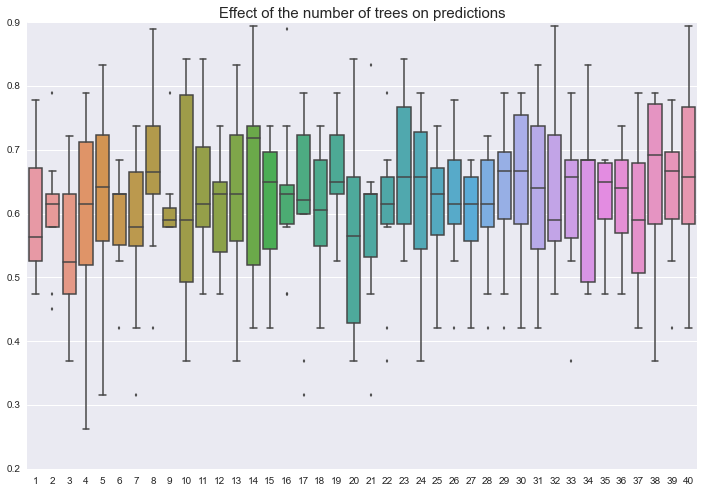

In [21]:
#How good at prediction is my tree? (I ran 40 different test, so each bar is one test).
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.title('Effect of the number of trees on predictions', fontsize=15)
sns.boxplot(data=scores)
#sns.boxplot(scores) #NOTE: Use this line if you have the older version of seaborn!!
#Note: This is before correcting for the unbalanced sample size. 

In [22]:
#Let's start by making 40 different 'trees' (based on decisions)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

#Unlike above, now we want to make 40 different forests, each conaining the same number of trees (15)
n_trees = [15]*40
scores = []
#This will make 40 forests, and each forest will be made up of 1-40 trees successively
#This way, we can see how much of an effect adding more trees has on the predictions.
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    val_score = cross_val_score(forest, X=X, y=Y, cv=10)
    scores.append(val_score) 

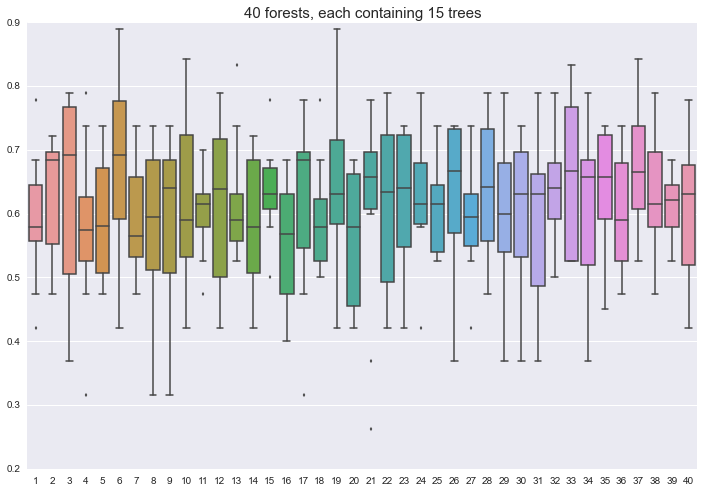

In [23]:
#How good at prediction is my tree? (I ran 40 different test, so each bar is one test).
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.title('40 forests, each containing 15 trees', fontsize=15)

sns.boxplot(data=scores)
#Note: This is before correcting for the unbalanced sample size. 

In [24]:
## your code here
non_erupt = 0.
for eruption in Y:
    if eruption == 0:
        non_erupt = non_erupt+1.
avg = non_erupt/len(Y)
print avg
print '%d percent of filaments do NOT erupt. Our sample is not balanced' % (avg*100)

0.534031413613
53 percent of filaments do NOT erupt. Our sample is not balanced


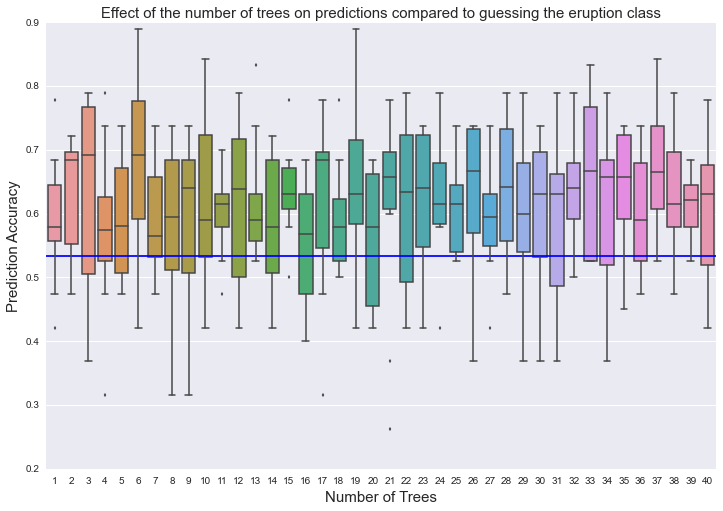

In [26]:
plt.figure(figsize=(12,8))
plt.axhline(y=avg)
plt.title('Effect of the number of trees on predictions compared to guessing the eruption class', fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Prediction Accuracy', fontsize=15)
sns.boxplot(data=scores)
#sns.boxplot(scores)

In [27]:
scores_2 = []
for i in n_trees:
    forest_2 = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    #Same thing, but using a different type of scoring (f1)
    #The F1 score is defined as the harmonic mean of recall and precision
    #So this tries to balance how well it does at picking out all of the erupting filaments and how many erupting filaments it is correct about
    val_score_2 = cross_val_score(forest_2, X=X, y=Y, cv=10, scoring='f1')
    scores_2.append(val_score_2) 

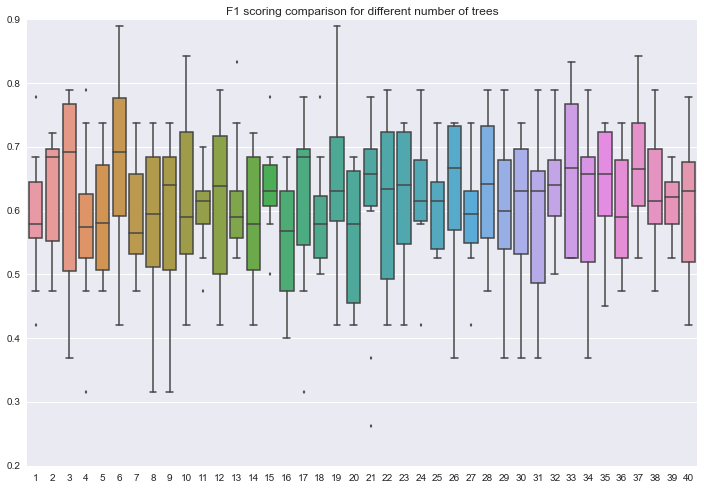

In [30]:
plt.figure(figsize=(12,8))
plt.title('F1 scoring comparison for different number of trees')
sns.boxplot(data=scores)
#sns.boxplot(scores)

I don't really see a big difference between the two types of scoring...

In [36]:
#make the forest classifier and do that fit. Then find the probabilities
forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
fitted_forest = forest.fit(X, Y)
proba = fitted_forest.predict_proba(X)

#Make a prediction based on probabilities
class_predict = fitted_forest.predict(X)
print class_predict[:10]


#Now just make a prediction based on raw values of the probabilities
erupt_good = proba[:, 1]
sanity_predict = [0]*len(erupt_good)
print erupt_good[:10]
for i in range(len(sanity_predict)):
    if erupt_good[i] > 0.5:
        sanity_predict[i] = 1
    else:
        sanity_predict[i] = 0
        
        
print sanity_predict[:10]
#val_score = cross_val_score(forest, X=X, y=Y, cv=10)
#scores.append(val_score) 

(class_predict == sanity_predict).all()

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
[ 0.73333333  0.8         0.73333333  1.          0.8         0.8         1.
  1.          0.86666667  0.46666667]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


True

In [37]:
#Which features are leading to the good predictions?
feature_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#by_feature = feature_forest.feature_importances_
fitted_forest4a = forest.fit(X, Y)
val_score_ = cross_val_score(fitted_forest4a, X=X, y=Y, cv=10)
imp_features = fitted_forest4a.feature_importances_

print imp_features

[ 0.09602103  0.07999097  0.12910668  0.07748968  0.16538075  0.07439982
  0.10869438  0.14925915  0.11965755]


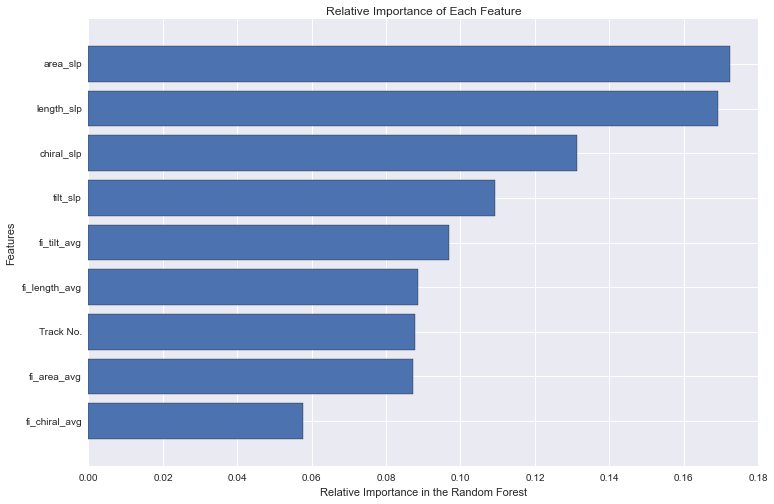

In [38]:
#Whitch features are most useful for prediction?
plt.figure(figsize=(12,8))
clf = RandomForestClassifier(n_estimators=15)

clf.fit(X,Y)
importance_list = clf.feature_importances_
name_list = all_eruptions.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature')
plt.show()

In [40]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired)
    plt.show()

In [27]:
#Look at the predictions.
#eruptions_subset = all_eruptions[['tilt_slp','area_slp']].as_matrix()


#subset_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#fitted_subset = subset_forest.fit(eruptions_subset, Y)
#subset_val_score = cross_val_score(subset_forest, X=wine_subset, y=Y, cv=10)
#plt.title('Random Forest Decision Tree Surface')
#plot_decision_surface(fitted_subset, eruptions_subset, Y)

In [28]:
#eruptions_subset = all_eruptions[['fi_tilt_avg','fi_area_avg']].as_matrix()


#subset_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#fitted_subset = subset_forest.fit(eruptions_subset, Y)
#subset_val_score = cross_val_score(subset_forest, X=wine_subset, y=Y, cv=10)
#plt.title('Random Forest Decision Tree Surface')
#plot_decision_surface(fitted_subset, eruptions_subset, Y)

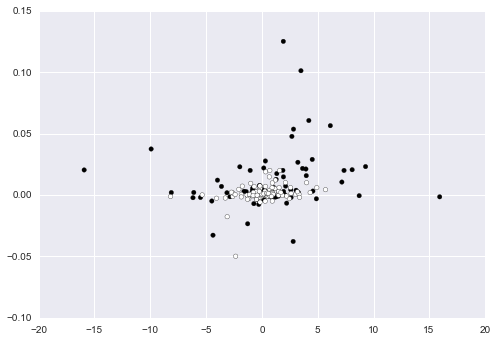

In [41]:
colors = Y
plt.scatter(all_eruptions['tilt_slp'],all_eruptions['area_slp'], c=colors)

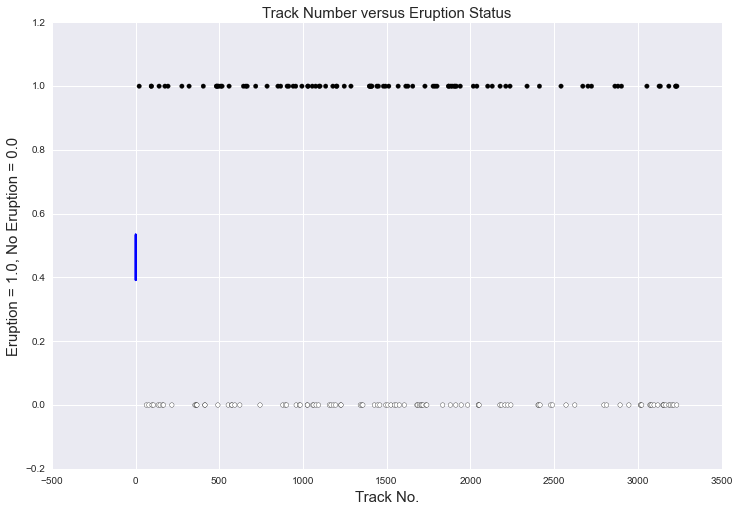

In [42]:
area_slp_X=all_eruptions['area_slp']
clf = linear_model.LinearRegression()
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(all_eruptions['Track No.'], Y, c=colors)
plt.title('Track Number versus Eruption Status', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.xlabel('Track No.', fontsize = 15)
clf.fit(all_eruptions['Track No.'][:,np.newaxis],Y)
plt.plot(area_slp_X, clf.predict(all_eruptions['Track No.'][:,np.newaxis]), color='blue')

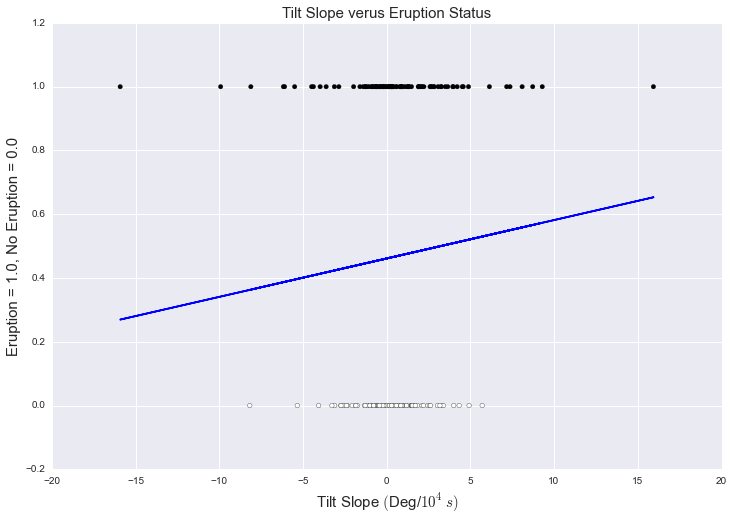

In [43]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
clf = linear_model.LinearRegression()
tilt_slp_X = np.array(all_eruptions['tilt_slp'])
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(tilt_slp_X, Y, c=colors)
#clf = Ridge(alpha=1.0)
#clf = linear_model.LogisticRegression(C=1e3)
clf = linear_model.LinearRegression()
clf.fit(tilt_slp_X[:,np.newaxis],Y)
plt.clf()
plt.scatter(tilt_slp_X, Y, c=colors)
plt.plot(tilt_slp_X, clf.predict(tilt_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Tilt Slope verus Eruption Status', fontsize = 15)
plt.xlabel(r'Tilt Slope $($Deg/$10^4s)$', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.figure(figsize=(12,8))
Y_predict = clf.predict(tilt_slp_X[:,np.newaxis])
#fig.gca().set_xlabel(r'wavelength $5000 \AA$')

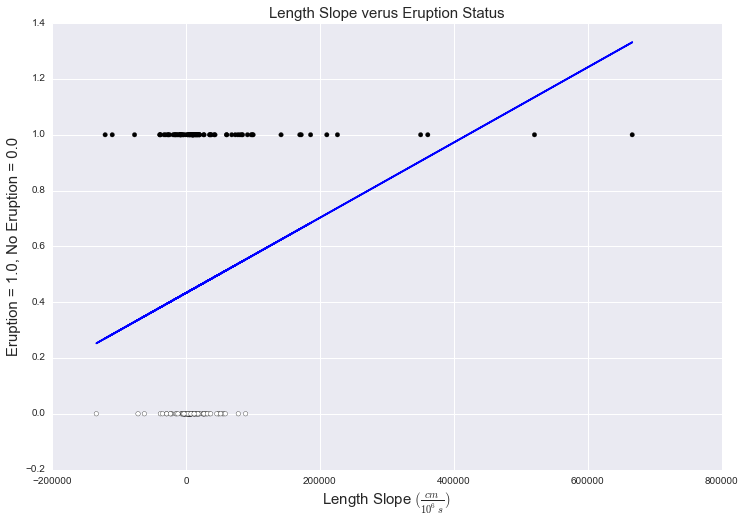

In [44]:
clf = linear_model.LinearRegression()
length_slp_X = np.array(all_eruptions['length_slp'])
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(length_slp_X, Y, c=Y)
clf.fit(length_slp_X[:,np.newaxis],Y)
plt.plot(length_slp_X, clf.predict(length_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Length Slope verus Eruption Status', fontsize = 15)
plt.xlabel(r'Length Slope $(\frac{cm}{10^6s})$', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.grid(True)
plt.show()

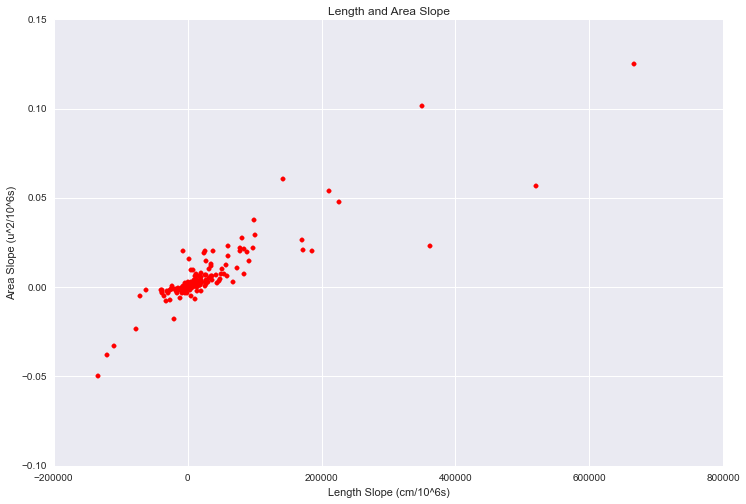

In [45]:
#clf = linear_model.LinearRegression()
length_slp_X = np.array(all_eruptions['length_slp'])
area_slp_X = np.array(all_eruptions['area_slp'])
plt.figure(figsize=(12,8))
plt.scatter(length_slp_X, area_slp_X, color='red')
#clf.fit(length_slp_X[:,np.newaxis],Y)
#plt.plot(length_slp_X, clf.predict(length_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Length and Area Slope')
plt.xlabel('Length Slope (cm/10^6s)')
plt.ylabel('Area Slope (u^2/10^6s)')
plt.grid(True)
plt.show()

# Taking out the data that doesn't seem to contribute

In [46]:
good_eruptions = all_eruptions.drop(['Track No.', 'fi_length_avg', 'fi_tilt_avg', 'fi_area_avg', 'fi_chiral_avg', 'chiral_slp'], 1)

In [47]:

X_2 = good_eruptions.as_matrix()
print X_2

[[  1.42711237e+04  -2.16171483e-03  -6.17617259e+00]
 [  5.63591761e+03  -4.86603184e-03  -4.48897738e+00]
 [ -2.67607848e+04  -7.00773105e-03  -7.21630702e-01]
 [  1.00417841e+05   2.90198308e-02   4.51088448e+00]
 [  1.29417091e+04   7.60396740e-03  -1.69295940e-01]
 [ -1.54849828e+04  -1.08642013e-03   5.32080968e-01]
 [  3.56143128e+04   1.21276845e-02  -3.98089563e+00]
 [  8.07226412e+04   2.77389143e-02   3.12824990e-01]
 [  7.98448403e+03   7.28213988e-04  -6.30676655e-01]
 [ -8.41784304e+02  -4.18643453e-04  -3.48871722e-01]
 [  1.72227408e+05   2.06214427e-02   8.08632809e+00]
 [  1.86255281e+05   2.00356780e-02   7.35956643e+00]
 [  1.14860072e+04   2.01843198e-03  -8.11952818e+00]
 [  9.60837804e+03   3.63541589e-03  -1.85098970e-01]
 [  1.72943180e+04   6.10666825e-03   1.06634028e+00]
 [ -1.59706955e+04  -3.50374807e-03   1.38338874e-01]
 [  1.95684578e+04   7.69843245e-03  -2.23350543e-01]
 [ -1.20584327e+05  -3.78118609e-02   2.80175863e+00]
 [  6.10054030e+04   1.74751

# rerunning the random forest classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

n_trees = [15]*40 #Again, each forest will have 15 trees
scores = []
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i)
    val_score = cross_val_score(forest, X=X_2, y=Y, cv=10)
    scores.append(val_score) 

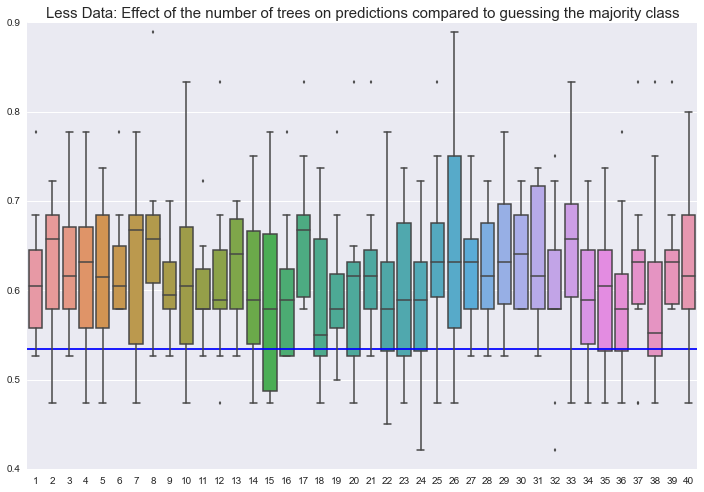

In [50]:
plt.figure(figsize=(12,8))
plt.axhline(y=avg)
plt.title('Less Data: Effect of the number of trees on predictions compared to guessing the majority class', fontsize=15)
sns.boxplot(data=scores)
#sns.boxplot(scores)

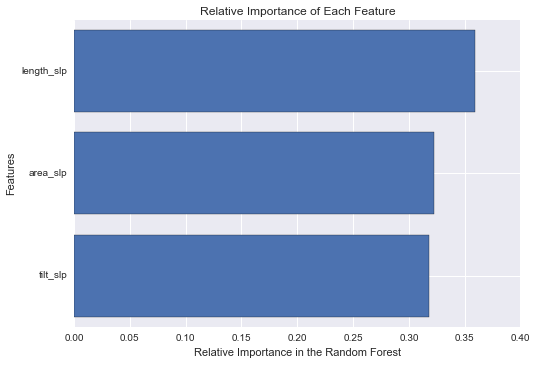

In [51]:
#Whitch features are most useful for prediction?
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X_2,Y)
importance_list = clf.feature_importances_
name_list = good_eruptions.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature')
plt.show()